# Chorus Example: Running LegNet predictions


## Installation Instructions (Reference)

If you haven't installed Chorus yet, follow these steps:

```bash
# 1. Clone the repository
git clone https://github.com/pinellolab/chorus.git
cd chorus

# 2. Create the main Chorus environment
mamba env create -f environment.yml
mamba activate chorus

# 3. Install Chorus package
pip install -e .

# 4. Set up the Sei environment
chorus setup --oracle legnet

# 5. Download the reference genome
chorus genome download hg38
```

**Note**: 
- For this notebook, we assume Chorus is already installed.
- pyGenomeTracks is now included in the environment for advanced visualization!

## Setup and Imports

In [1]:
# Import required libraries
import chorus
from chorus.utils import get_genome, extract_sequence, download_gencode
from chorus.utils.visualization import visualize_chorus_predictions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Set up matplotlib for inline display
import matplotlib
matplotlib.use('Agg')  # Use non-interactive backend
import matplotlib.pyplot as plt

# Set up plotting with white background
%matplotlib inline
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.dpi'] = 100  # Increase DPI for better quality

print("Chorus version:", chorus.__version__ if hasattr(chorus, '__version__') else "development")

Chorus version: 0.1.0


## 1. Setting up Reference Genome and Sei Oracle

In [2]:
# Download gene annotations
print("\nSetting up gene annotations...")
gtf_path = download_gencode(version='v48', annotation_type='basic')
print(f"Using annotations: {gtf_path}")


Setting up gene annotations...
Using annotations: /home/penzard/pinellolab/chorus/annotations/gencode.v48.basic.annotation.gtf.gz


In [3]:
# Get reference genome (auto-downloads if not present)
print("Setting up reference genome...")
genome_path = get_genome('hg38')
print(f"Using genome: {genome_path}")

# Create Enformer oracle with environment isolation
print("\nCreating LegNet oracle...")
# For different configurations:
# - Force CPU: device='cpu'
# - Use specific GPU: device='cuda:0'
oracle = chorus.create_oracle(
    'legnet',
    cell_line="HepG2",
    sliding_predict=True,
    use_environment=True,
    reference_fasta=str(genome_path),
    device="cpu:0",
)

# Load pre-trained model
print("\nLoading pre-trained Sei model...")
print("To force CPU usage: device='cpu'")
print("To disable timeout: export CHORUS_NO_TIMEOUT=1")
oracle.load_pretrained_model(weights="/home/penzard/pinellolab/chorus/chorus/oracles/legnet/")
print("Model loaded successfully!")

Setting up reference genome...
Using genome: /home/penzard/pinellolab/chorus/genomes/hg38.fa

Creating LegNet oracle...

Loading pre-trained Sei model...
To force CPU usage: device='cpu'
To disable timeout: export CHORUS_NO_TIMEOUT=1
Model loaded successfully!


## 2. Exploring Available Tracks

For LegNet model only MPRA assay for cell line you specified is available. 

In [4]:
# List available assay types
assay_types = oracle.list_assay_types()
print(f"Available assay types ({len(assay_types)}):")
print(assay_types)
# List available cell types (show first 20 due to large number)
cell_types = oracle.list_cell_types()
print(f"Available cell types ({len(cell_types)}):")
print(cell_types)

Available assay types (1):
['MPRA']
Available cell types (1):
['HepG2']


## Example A: Wild-type Sequence Prediction


In [5]:
# Define GATA1 TSS region
gata1_region = "chrX:48777634-48790694"
print(f"Analyzing wild-type region: {gata1_region}")
print("This region contains the GATA1 transcription start site\n")

# Extract sequence information
wt_seq = extract_sequence(gata1_region, str(genome_path))
print(f"Region length: {len(wt_seq):,} bp")
print(f"GC content: {(wt_seq.count('G') + wt_seq.count('C')) / len(wt_seq) * 100:.1f}%")

Analyzing wild-type region: chrX:48777634-48790694
This region contains the GATA1 transcription start site

Region length: 13,061 bp
GC content: 47.2%


In [6]:
wt_results = oracle.predict(
    ('chrX', 48777634, 48790694),
)

# Print statistics
for track_id, predictions in wt_results.items():
    print(f"\n{track_id}:")
    print(f"  Shape: {predictions.shape}")
    print(f"  Mean signal: {np.mean(predictions):.4f}")
    print(f"  Max signal: {np.max(predictions):.4f}")


HepG2:
  Shape: (262,)
  Mean signal: -0.7415
  Max signal: 0.7079



Saving wild-type tracks...
Saved 1 files to bedgraph_outputs/

Creating visualization with gene annotations...


/home/penzard/pinellolab/chorus/chorus/utils/visualization.py:562: UserWarning: Error creating pyGenomeTracks plot: PlotTracks.__init__() got an unexpected keyword argument 'width'
  warnings.warn(f"Error creating pyGenomeTracks plot: {e}")


Saved visualization to: gata1_wt_with_genes.png


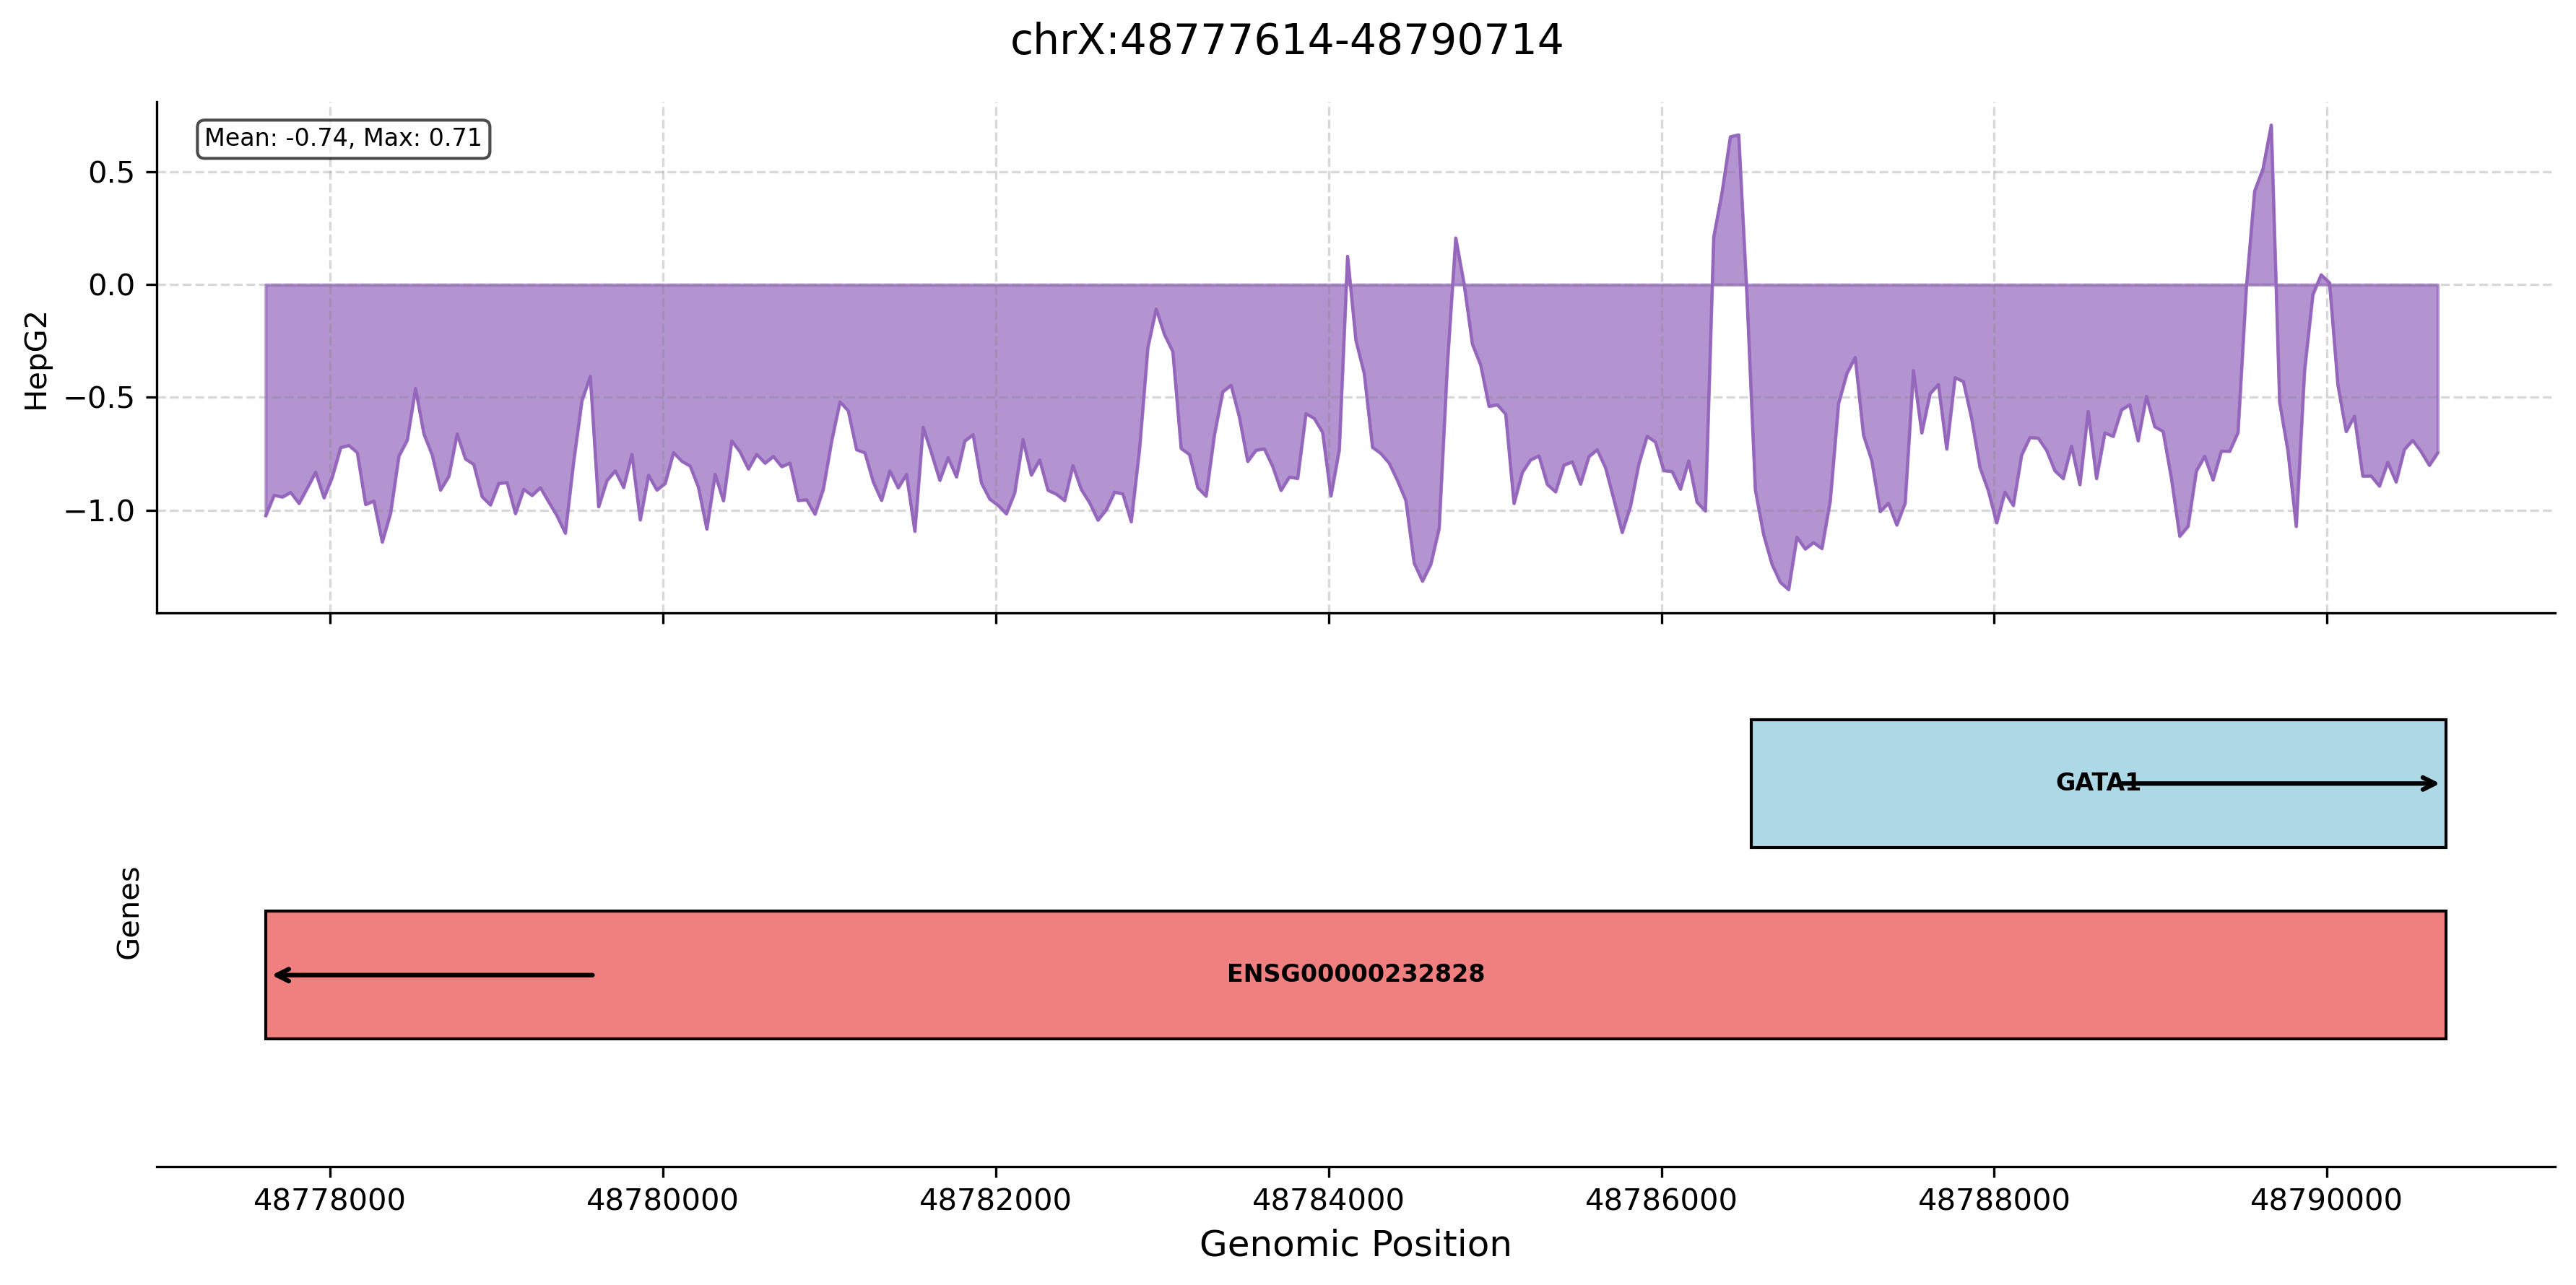

In [7]:
# Save tracks using oracle method - Enformer handles coordinate mapping internally
print("\nSaving wild-type tracks...")

wt_files = oracle.save_predictions_as_bedgraph(
    predictions=wt_results,
    chrom='chrX',
    start=wt_results.metainfo['positions'][0] ,
    output_dir="bedgraph_outputs",
    prefix='a_wt'
)
print(f"Saved {len(wt_files)} files to bedgraph_outputs/")

# Create visualization with gene annotations using pyGenomeTracks
print("\nCreating visualization with gene annotations...")
try:
    visualize_chorus_predictions(
        predictions=wt_results,
        track_ids=list(wt_results.keys()),
        chrom='chrX',
        start=wt_results.metainfo['positions'][0],  # Use output window start for visualization
        output_file='gata1_wt_with_genes.png',  # Save to file for pyGenomeTracks
        bin_size=oracle.bin_size,
        style='modern',
        gtf_file=str(gtf_path),  # Add gene annotations
        use_pygenometracks=True  # Use pyGenomeTracks for better gene visualization
    )
    print("Saved visualization to: gata1_wt_with_genes.png")
    
    # Display the saved image
    from IPython.display import Image, display
    display(Image('gata1_wt_with_genes.png', width=800))
    
except Exception as e:
    print(f"Could not create pyGenomeTracks visualization: {e}")
    print("Falling back to matplotlib visualization...")
    
    # Fallback to matplotlib for inline display
    visualize_chorus_predictions(
        predictions=wt_results,
        chrom='chrX',
        start=output_start,
        track_ids=list(wt_results.keys()),
        output_file=None,  # Display inline
        bin_size=oracle.bin_size,
        style='modern',
        gtf_file=str(gtf_path),
        use_pygenometracks=False
    )

## Example B: Region Replacement

Replace a sub-region with a synthetic sequence and analyze the effects.

In [8]:
# Define replacement parameters
replace_region = "chrX:48782929-48783129"
replacement_seq = "CTGCTTGCTTTAGCTTCAGGGTTCTTATCTTTTTTCATTTTATAACAGCAAAGGCGACACCCAACATGTGCGTGCTTGAGATAATGACTAAAAACTGCCCGTGACTCAAGCGCTTCTGGTGAGGGAAGATAAGGCAAGGAAACTGGCCGCCTAGATAGCCCTGGGAATGAGGCAGTCTCTGTTCTGGGTAAAGTGTCTGC"

print(f"Replacing region: {replace_region}")
print(f"Original region length: 200 bp")
print(f"Replacement sequence length: {len(replacement_seq)} bp")
print(f"\nReplacement sequence (first 50 bp): {replacement_seq[:50]}...")

Replacing region: chrX:48782929-48783129
Original region length: 200 bp
Replacement sequence length: 200 bp

Replacement sequence (first 50 bp): CTGCTTGCTTTAGCTTCAGGGTTCTTATCTTTTTTCATTTTATAACAGCA...


In [9]:
# Make predictions with replacement
print("Making predictions with replaced region...\n")
replacement_results = oracle.predict_region_replacement(
            assay_ids=list(wt_results.keys()),
    genomic_region=replace_region,
    seq=replacement_seq,
    create_tracks=False,
    genome=str(genome_path)
)

# Analyze changes
print("Signal changes due to replacement:")
for track_id in ['HepG2']:
    predictions = replacement_results['raw_predictions'][track_id]
    print(f"\n{track_id}:")
    print(f"  Signal: {predictions[0]:.4f}")
   

Making predictions with replaced region...

Signal changes due to replacement:

HepG2:
  Signal: -0.5295


## Example C: Sequence Insertion

Insert the same sequence at a different position to see how location affects predictions.

In [10]:
# Define insertion parameters
insertion_pos = "chrX:48781929"
insert_seq = replacement_seq  # Use same sequence as before

print(f"Inserting at position: {insertion_pos}")
print(f"Insert sequence length: {len(insert_seq)} bp")
print("This insertion is ~1kb upstream of the replacement position")

Inserting at position: chrX:48781929
Insert sequence length: 200 bp
This insertion is ~1kb upstream of the replacement position


In [11]:
# Make predictions with insertion
print("\nMaking predictions with insertion...\n")
insertion_results = oracle.predict_region_insertion_at(
    assay_ids=['HepG2'],
    genomic_position=insertion_pos,
    seq=insert_seq,
    create_tracks=False,
    genome=str(genome_path)
)

# Analyze impact around insertion site
print("Impact of insertion:")
for track_id in insertion_results['raw_predictions']:
    predictions = insertion_results['raw_predictions'][track_id]
    # Center of output is where insertion occurs
    center = len(predictions) // 2
    window = 20
    local_signal = predictions[center-window:center+window]
    
    print(f"\n{track_id}:")
    print(f"  Signal: {predictions[0]:.4f}")


Making predictions with insertion...

Impact of insertion:

HepG2:
  Signal: -0.3984


In [12]:
insertion_results

{'raw_predictions': {'HepG2': MetaInfoArray([-0.3984339], dtype=float32)},
 'normalized_scores': {'HepG2': MetaInfoArray([-0.3984339], dtype=float32)}}

## Example D: Variant Effect Analysis

Test the effect of single nucleotide polymorphisms (SNPs) at a specific position.

In [20]:
# Define variant to test
variant_pos = 48786129
ref_seq = 'C'  # Corrected reference allele from 'G' to 'C'

print(f"Testing variant at chrX:{variant_pos}")
print(f"Reference allele: {ref_seq}")

# Create alleles list with reference first, then alternatives
alt_alleles = [a for a in ['A', 'C', 'G', 'T'] if a != ref_seq]
test_alleles = [ref_seq] + alt_alleles  # Reference first, then alternatives

print(f"Testing substitutions: {ref_seq} -> {', '.join(alt_alleles)}")

# Need a wider region for variant analysis
print("\nPredicting variant effects...\n")
variant_results = oracle.predict_variant_effect(
    genomic_region=f"chrX:{variant_pos-5000}-{variant_pos+5000}",
     assay_ids=['HepG2'],
    variant_position=f"chrX:{variant_pos}",
    alleles=test_alleles,  # Reference first, then alternatives
    genome=str(genome_path)
)

print("\nVariant predictions completed!")

Testing variant at chrX:48786129
Reference allele: C
Testing substitutions: C -> A, G, T

Predicting variant effects...


Variant predictions completed!


In [21]:
# Analyze variant effects
print("Variant effect analysis:")
print("=" * 60)

# Create results dataframe
variant_effects = []

# Check the structure first
print(f"\nVariant results keys: {variant_results.keys()}")
print(f"Predictions keys: {variant_results['predictions'].keys()}")

# Get reference predictions - it's a dictionary, not a 2D array
ref_predictions = variant_results['predictions']['reference']
print(f"\nReference predictions type: {type(ref_predictions)}")
if isinstance(ref_predictions, dict):
    print(f"Track IDs in predictions: {list(ref_predictions.keys())}")

for track_id in ['HepG2']:
    # Get reference signal for this track
    ref_signal = np.mean(ref_predictions[track_id])
    
    print(f"\n{track_id}:")
    print(f"  Reference ({ref_seq}) mean signal: {ref_signal:.4f}")
    print("  Variant effects:")
    
    # Add reference to dataframe
    variant_effects.append({
        'Track': track_id,
        'Allele': ref_seq,
        'Signal': ref_signal,
        'Effect': 0.0,
        'Is_Reference': True
    })
    
    # Add alternatives
    for i, allele in enumerate(alt_alleles):
        allele_key = f'alt_{i+1}'
        if allele_key in variant_results['predictions']:
            alt_predictions = variant_results['predictions'][allele_key]
            alt_signal = np.mean(alt_predictions[track_id])
            effect = alt_signal - ref_signal
            print(f"    {allele}: {alt_signal:.4f} (Δ = {effect:+.4f})")
            
            variant_effects.append({
                'Track': track_id,
                'Allele': allele,
                'Signal': alt_signal,
                'Effect': effect,
                'Is_Reference': False
            })

# Create DataFrame for easier analysis
variant_df = pd.DataFrame(variant_effects)
variant_df

Variant effect analysis:

Variant results keys: dict_keys(['predictions', 'effect_sizes', 'track_objects', 'track_files', 'variant_info'])
Predictions keys: dict_keys(['reference', 'alt_1', 'alt_2', 'alt_3'])

Reference predictions type: <class 'dict'>
Track IDs in predictions: ['HepG2']

HepG2:
  Reference (C) mean signal: -0.5639
  Variant effects:
    A: -0.5639 (Δ = +0.0000)
    G: -0.5639 (Δ = +0.0000)
    T: -0.5639 (Δ = +0.0000)


,Track,Allele,Signal,Effect,Is_Reference
0,HepG2,C,-0.56390554,0.0,True
1,HepG2,A,-0.56390554,0.0,False
2,HepG2,G,-0.56390554,0.0,False
3,HepG2,T,-0.56390554,0.0,False


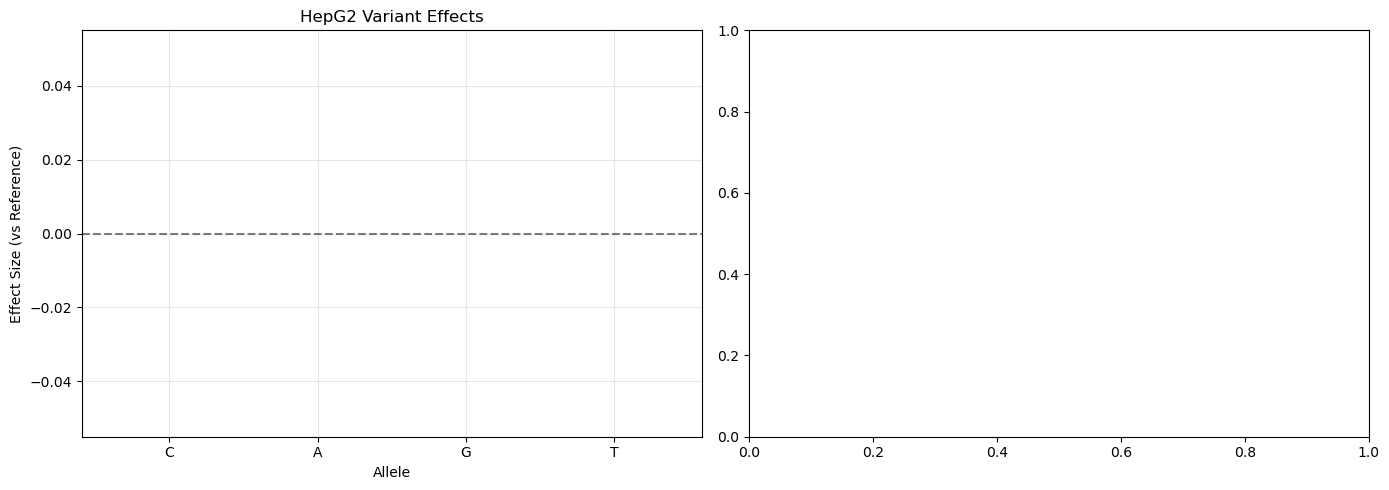


Saving variant tracks...


In [22]:
# Visualize variant effects as bar chart
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for idx, track_id in enumerate(['HepG2']):
    track_data = variant_df[variant_df['Track'] == track_id]
    
    colors = ['red' if is_ref else 'blue' 
              for is_ref in track_data['Is_Reference']]
    
    axes[idx].bar(track_data['Allele'], track_data['Effect'], color=colors)
    axes[idx].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    axes[idx].set_title(f"{track_id} Variant Effects")
    axes[idx].set_xlabel('Allele')
    axes[idx].set_ylabel('Effect Size (vs Reference)')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
# Display the figure
from IPython.display import display
display(fig)
plt.close()

# Save variant tracks
print("\nSaving variant tracks...")

# Save reference - predictions are already in the correct dictionary format
ref_preds = variant_results['predictions']['reference']
oracle.save_predictions_as_bedgraph(
    predictions=ref_preds,
    chrom='chrX',
    start=variant_pos,
    output_dir="bedgraph_outputs",
    prefix=f'd_variant_{ref_seq}'
)

# Save alternatives
for i, allele in enumerate(alt_alleles):
    allele_key = f'alt_{i+1}'
    if allele_key in variant_results['predictions']:
        # Predictions are already in the correct dictionary format
        variant_preds = variant_results['predictions'][allele_key]
        oracle.save_predictions_as_bedgraph(
            predictions=variant_preds,
            chrom='chrX',
            start=variant_pos,
            output_dir="bedgraph_outputs",
            prefix=f'd_variant_{allele}'
        )


## Example E: Direct Sequence Prediction

Demonstrate prediction on a synthetic sequence without genomic coordinates.

In [23]:
# Create a synthetic sequence with known regulatory elements
print("Creating synthetic sequence with regulatory elements...\n")

# Enformer requires exactly 393,216 bp
context_size = 393216

# Define regulatory elements
promoter_elements = {
    'TATA_box': 'TATAAA',
    'CAAT_box': 'CCAAT',
    'GC_box': 'GGGCGG',
    'GATA_motif': 'GATA',
    'E_box': 'CACGTG'
}

print("Regulatory elements used:")
for name, seq in promoter_elements.items():
    print(f"  {name}: {seq}")

Creating synthetic sequence with regulatory elements...

Regulatory elements used:
  TATA_box: TATAAA
  CAAT_box: CCAAT
  GC_box: GGGCGG
  GATA_motif: GATA
  E_box: CACGTG


In [24]:
# Build synthetic sequence
print("\nBuilding synthetic sequence...")
seq_parts = []
element_positions = []

for i in range(0, context_size, 1000):
    if i % 5000 == 0:
        # Add strong promoter every 5kb
        motifs = ''.join([
            promoter_elements['TATA_box'],
            'N' * 20,
            promoter_elements['CAAT_box'],
            'N' * 50,
            promoter_elements['GC_box']
        ])
        seq_parts.append(motifs)
        element_positions.append((i, 'promoter'))
    elif i % 3000 == 0:
        # Add enhancer elements
        enhancer = (promoter_elements['GATA_motif'] + 'NNNN') * 5
        seq_parts.append(enhancer)
        element_positions.append((i, 'enhancer'))
    else:
        # Random sequence
        seq_parts.append('ACGT' * 250)

# Combine and adjust to exact size
synthetic_seq = ''.join(seq_parts)[:context_size]

# Pad if needed
if len(synthetic_seq) < context_size:
    synthetic_seq += 'A' * (context_size - len(synthetic_seq))

print(f"\nFinal sequence length: {len(synthetic_seq):,} bp")
print(f"Number of promoter elements: {sum(1 for _, t in element_positions if t == 'promoter')}")
print(f"Number of enhancer elements: {sum(1 for _, t in element_positions if t == 'enhancer')}")


Building synthetic sequence...

Final sequence length: 393,216 bp
Number of promoter elements: 79
Number of enhancer elements: 105


In [25]:
# Make predictions on synthetic sequence
print("\nMaking predictions on synthetic sequence...\n")
synthetic_results = oracle.predict(
    synthetic_seq,
)

# Analyze predictions
print("Synthetic sequence predictions:")
for track_id, predictions in synthetic_results.items():
    print(f"\n{track_id}:")
    print(f"  Shape: {predictions.shape}")
    print(f"  Mean signal: {np.mean(predictions):.4f}")
    print(f"  Max signal: {np.max(predictions):.4f}")
    
    # Find top peaks
    top_bins = np.argsort(predictions)[-5:]
    print(f"  Top 5 peak bins: {top_bins}")
    print(f"  Peak values: {predictions[top_bins]}")


Making predictions on synthetic sequence...

Synthetic sequence predictions:

HepG2:
  Shape: (7865,)
  Mean signal: 1.0629
  Max signal: 1.7350
  Top 5 peak bins: [2990 1555 1892 3662 1220]
  Peak values: [1.7302868 1.7308589 1.7314949 1.733872  1.7349734]


Visualizing synthetic sequence predictions...


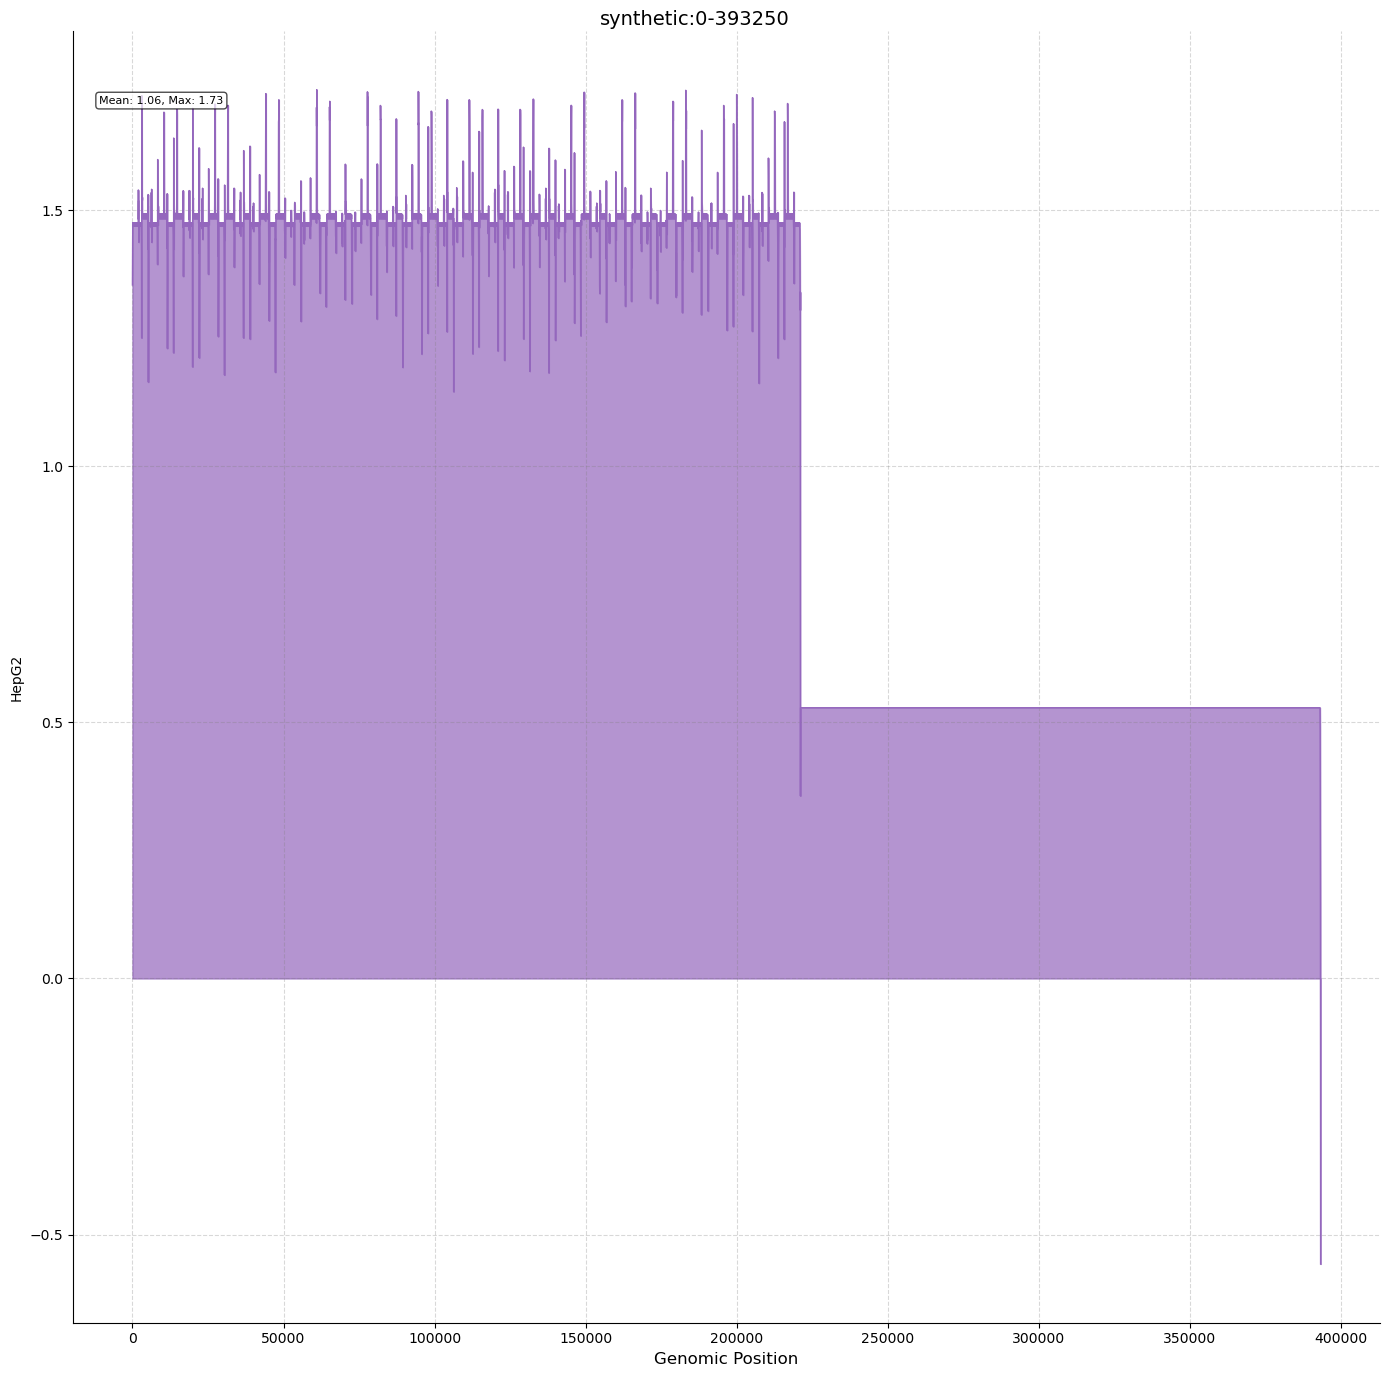


Saving synthetic sequence tracks...
Saved 1 files


In [26]:
# Visualize synthetic sequence predictions with improved plotting
print("Visualizing synthetic sequence predictions...")

visualize_chorus_predictions(
    predictions=synthetic_results,
    track_ids=['HepG2'],
    chrom='synthetic',
    start=0,
    output_file=None,
    bin_size=oracle.bin_size,
    style='modern',
    figsize=(14, 14)
)

# Save synthetic tracks
print("\nSaving synthetic sequence tracks...")
synthetic_files = oracle.save_predictions_as_bedgraph(
    predictions=synthetic_results,
    chrom='synthetic',
    start=0,
    output_dir="bedgraph_outputs",
    prefix='e_synthetic'
)
print(f"Saved {len(synthetic_files)} files")